# Import Packages

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Directory Variables

In [2]:
paperfolder = '\\OneDrive - Northwestern University\\Documents - Backman Lab - Shared Folders\\Lab Paper Drafts'
parent_folder = glob.glob('C:\\Users\\**'+paperfolder)[0]+'\\FISH vs. CRISPR'
orig_data = parent_folder + '\\iScience Manuscript Files\\Data'
first_rev_data = parent_folder + '\\PLOS ONE Manuscript Files\\iScience Revision Experiments'
sec_rev_data = parent_folder + '\\PLOS ONE Revision Files\\PLOS ONE Revision Experiments'
save_fold = parent_folder + '\\PLOS ONE Revision Files'

# Read in Data and Compile into Files for Plotting/Submission

In [3]:
col_order = ['Experiment','Condition','Labeling Protocol','Labeling Target','Date Imaged','Replicate','PWS Analysis',
             'ROI Name','Cell#','ROI#','RMS','Normalized RMS','D','Normalized D','Roi Area','Reflectance','Path']
fish_paper_data = pd.DataFrame(columns=col_order)

########## Read in Anne's full 3D FISH protocol PWS data
fish_anne_dir = orig_data + '\\Full_Protocol'
cond_names = ['Live','PFA','Triton X-100','HCl','RNase A','Formamide','Heat','Overnight']
full_names = ['WT','PFA','TritonX','HCl','RNAse','Form','DexAHeat','Overnight']
full_dates = ['2/8/2021','2/10/2021','2/12/2021']
for num,folder in enumerate(['21-2-8','21-2-10','21-2-12']):
    for cnum,file in enumerate(full_names):
        fullprot = pd.read_csv(fish_anne_dir+'\\'+folder+'\\D-'+full_names[cnum]+'.csv',index_col=0)
        fullprot['Experiment'] = 'Full 3D FISH Protocol'
        fullprot['Labeling Protocol'] = '3D FISH'
        fullprot['Labeling Target'] = 'No Label'
        fullprot['Date Imaged'] = full_dates[num]
        fullprot['Replicate'] = num + 1
        fullprot['Condition'] = cond_names[cnum]
        fullprot['ROI Name'] = 'nuc'
        if file=='WT':
            norm_rms = fullprot.RMS.mean()
            norm_d = fullprot.D.mean()
        fullprot['Normalized RMS'] = fullprot.RMS/norm_rms
        fullprot['Normalized D'] = fullprot.D/norm_d
        fish_paper_data = pd.concat([fish_paper_data,fullprot],ignore_index=True)
        
########## Read in Anne's individual 3D FISH reagent PWS data
ind_reag_dir = orig_data + '\\Individual_Reagents'
ind_names = ['WT','PFA','TritonX','HCl','RNAse','Form2XSSC','AfterHeat','Overnight']
for num,file in enumerate(ind_names):
    indreag = pd.read_csv(ind_reag_dir+'\\D-'+ind_names[num]+'.csv',index_col=0)
    indreag['Experiment'] = 'Individual 3D FISH Reagents'
    indreag['Labeling Protocol'] = '3D FISH'
    indreag['Labeling Target'] = 'No Label'
    indreag['Date Imaged'] = '2/9/2021'
    indreag['Replicate'] = 1
    inc = indreag['Cell#'] >= indreag['Cell#'].shift(1, fill_value=1)
    for ind in inc[~inc].index:
        indreag.loc[ind:,'Replicate'] += 1
    indreag['Condition'] = cond_names[num]
    indreag['ROI Name'] = 'nuc'
    if file=='WT':
        norm_rms = indreag.RMS.mean()
        norm_d = indreag.D.mean()
    indreag['Normalized RMS'] = indreag.RMS/norm_rms
    indreag['Normalized D'] = indreag.D/norm_d
    fish_paper_data = pd.concat([fish_paper_data,indreag],ignore_index=True)
    
########## Read in Josh's 3D FISH protocol optimization PWS data
fullcondnames = {'PFA_10':'10 min 4% PFA','PFA_30':'30 min 4% PFA','PFA_90':'90 min 4% PFA',
                 'GA_PFA':'10 min 2% PFA 2.5% GA','EtOH':'10 min 70% EtOH','MeOH':'10 min 100% MeOH'}
# Remove all FISH samples due to poor sample quality
form = pd.read_csv(sec_rev_data+'\\Fixation PWS\\FISH_PWS_12-2023_D.csv')
form = form[~form['Path'].str.contains('FISH')].copy()
form['Normalized RMS'] = form.RMS/form[form['Path'].str.contains('Live')].RMS.mean()
form['Normalized D'] = form.D/form[form['Path'].str.contains('Live')].D.mean()
form_split = form['Path'].str.split('\\')
form['Experiment'] = 'Fixation Optimization'
form.loc[form['Path'].str.contains('FISH'),'Experiment'] = 'Protocol Comparison'
form['Labeling Protocol'] = '3D FISH'
form['Labeling Target'] = 'No Label'
form.loc[form.Path.str.contains('Chr'),
         'Labeling Target'] = form_split.str[1][form.Path.str.contains('Chr')].str.replace('Chr','Chromosome ')
form['Date Imaged'] = form_split.str[0].str.split(' ').str[1].str.replace('-','/')
form['Condition'] = form_split.str[1]
form['Condition'] = form['Condition'].replace(fullcondnames)
form.loc[form.Path.str.contains('Live'),'Condition'] = 'Live'
form.loc[form.Path.str.contains('Fixed'),'Condition'] = form.loc[form.Path.str.contains('Fixed'),
                                                                 'Condition']+' After Fixation'
form.loc[form.Path.str.contains('Formamide'),'Condition'] = form.loc[form.Path.str.contains('Formamide'),
                                                                 'Condition']+' After Formamide'
form.loc[form.Path.str.contains('Chr'),'Condition'] = form['Labeling Target']+' '+form['Labeling Protocol']
form['Replicate'] = form_split.str[2].str.split('_').str[1].fillna('2')
fish_paper_data = pd.concat([fish_paper_data,form],ignore_index=True)

########## Read in Jane's 3D FISH protocol optimization PWS data
fish = pd.read_csv(first_rev_data+'\\FISH PWS Results.csv')
# Remove data from experiment with incorrect internal reflectance correction
fish = fish[fish['Date Imaged']!='10/26/2022'].copy()
for exp in [fish['Date Imaged']<'04/01/2022',fish['Date Imaged']>'04/01/2022']:
    fish.loc[exp,'Normalized RMS'] = fish[exp].RMS/fish[(fish.Condition=='Live')&(exp)].RMS.mean()
    fish.loc[exp,'Normalized D'] = fish[exp].D/fish[(fish.Condition=='Live')&(exp)].D.mean()
fish['Experiment'] = 'Optimization After Formamide'
fish['Labeling Protocol'] = '3D FISH'
fish['Labeling Target'] = 'No Label'
fish.Condition = fish.Condition.str.replace(' Hour',' Hours')
fish.Condition = fish.Condition.str.replace('15','12-15')
fish_paper_data = pd.concat([fish_paper_data,fish],ignore_index=True)

########## Read in Rachel's 3D FISH protocol optimization PWS data
fish_new = pd.read_csv(sec_rev_data+'\\Optimization PWS\\fish_optimization_01092024_D.csv')
fish_new['Date Imaged'] = '01/09/2024'
fish_new['Replicate'] = 4
fish_new.Condition = fish_new.Condition.str.replace('_75C','')
fish_new.loc[(fish_new.Condition.str.contains('12hr'))|(fish_new.Condition.str.contains('24hr')),
             'Date Imaged'] = '01/10/2024'
fish_new.loc[fish_new.Condition.str.contains('48hr'),'Date Imaged'] = '01/11/2024'
fish_new.loc[fish_new.Condition.str.contains('cont'),
             'Normalized RMS'] = fish_new.loc[fish_new.Condition.str.contains('cont'),
                                              'RMS']/fish_new.loc[fish_new.Condition.str.contains('live'),'RMS'].mean()
fish_new.loc[fish_new.Condition.str.contains('cont'),
             'Normalized D'] = fish_new.loc[fish_new.Condition.str.contains('cont'),
                                            'D']/fish_new.loc[fish_new.Condition.str.contains('live'),'D'].mean()
for cond in ['C','12hr','24hr','48hr']:
    if cond =='C':
        ctrlnorm = 'fixed_cont'
    else:
        ctrlnorm = cond+'_fixed cont'
    sample = (fish_new.Condition.str.contains(cond))&~(fish_new.Condition.str.contains('cont'))
    fish_new.loc[sample,'Normalized RMS'] = fish_new.loc[sample,'RMS']/fish_new.loc[fish_new.Condition==ctrlnorm,
                                                                                    'RMS'].mean()
    fish_new.loc[sample,'Normalized D'] = fish_new.loc[sample,'D']/fish_new.loc[fish_new.Condition==ctrlnorm,
                                                                                'D'].mean()
fish_new.Condition = fish_new.Condition.str.replace('live_cont','Live')
fish_new.Condition = fish_new.Condition.str.replace('hr',' Hours')
fish_new.Condition = fish_new.Condition.str.replace('12','12-15')
fish_new.loc[fish_new.Condition.str.contains('fixed'),'Condition'] = 'PFA'
fish_new['Experiment'] = 'Optimization After Formamide'
fish_new['Labeling Protocol'] = '3D FISH'
fish_new['Labeling Target'] = 'No Label'
fish_paper_data = pd.concat([fish_paper_data,fish_new],ignore_index=True)

########## Read in Tiffany's RASER-FISH PWS data
rasercont = pd.read_csv(sec_rev_data+'\\RASER-FISH PWS\\1-24-2024\\BrdU PWS_D_Jane.csv')
# Remove dishes with BrdU added
rasercont = rasercont[~rasercont.Path.str.contains('BrdU')].copy()
rasercont['Date Imaged'] = '1/24/2024'
rasercont.loc[rasercont.Path.str.contains('Fixed_Control'),'Condition'] = 'PFA'
rasercont.loc[rasercont.Path.str.contains('Live_Control'),'Condition'] = 'Live'
rasercont['Replicate'] = 2
rasercont.loc[rasercont.Path.str.contains('1'), 'Replicate'] = 1
rasercont.loc[rasercont.Path.str.contains('3'), 'Replicate'] = 3
rasercont['Normalized RMS'] = rasercont.RMS/rasercont[rasercont['Condition']=='Live'].RMS.mean()
rasercont['Normalized D'] = rasercont.D/rasercont[rasercont['Condition']=='Live'].D.mean()
rasercont['Experiment'] = 'Protocol Comparison'
rasercont['Labeling Protocol'] = 'RASER-FISH'
rasercont['Labeling Target'] = 'No Label'
fish_paper_data = pd.concat([fish_paper_data,rasercont],ignore_index=True)

raser = pd.read_csv(sec_rev_data+'\\RASER-FISH PWS\\RASERFISH_11-02-23_D.csv')
raser = raser[raser['Path']=='Dish 3']
raser['Date Imaged'] = '9/6/2023'
raser['Normalized RMS'] = raser.RMS/rasercont[rasercont['Condition']=='Live'].RMS.mean()
raser['Normalized D'] = raser.D/rasercont[rasercont['Condition']=='Live'].D.mean()
raser['Experiment'] = 'Protocol Comparison'
raser['Labeling Protocol'] = 'RASER-FISH'
raser['Labeling Target'] = 'Chromosome 19'
raser['Condition'] = raser['Labeling Target']+' '+raser['Labeling Protocol']
raser['Replicate'] = 1
fish_paper_data = pd.concat([fish_paper_data,raser],ignore_index=True)

########## Read in Rachel's 3D FISH PWS data
fishpws = pd.read_csv(sec_rev_data+'\\FISH PWS\\1-30-2024\\3D FISH PWS data_D.csv')
fishpws = fishpws[~fishpws.Path.str.contains('C3')]
fishpws['Date Imaged'] = '1/30/2024'
fishpws['Replicate'] = 1
fishpws.loc[fishpws.Path.str.contains('2'), 'Replicate'] = 2
fishpws['Experiment'] = 'Protocol Comparison'
fishpws['Labeling Protocol'] = '3D FISH'
fishpws['Labeling Target'] = 'No Label'
fishpws.loc[fishpws.Path.str.contains('C'),'Labeling Target'] = 'Chromosome 19'
fishpws['Condition'] = fishpws['Labeling Target']+' '+fishpws['Labeling Protocol']
fishpws.loc[fishpws.Path.str.contains('4PFA'),'Condition'] = 'PFA'
fishpws.loc[fishpws.Path.str.contains('Buffer'),'Condition'] = 'Mock Stain 3D FISH'
fishpws['Normalized RMS'] = fishpws.RMS/rasercont[rasercont['Condition']=='Live'].RMS.mean()
fishpws['Normalized D'] = fishpws.D/rasercont[rasercont['Condition']=='Live'].D.mean()
fish_paper_data = pd.concat([fish_paper_data,fishpws],ignore_index=True)

########## Read in Emily's CRISPR-Sirius PWS data
crispr_Emily = pd.read_csv(first_rev_data+'\\CRISPR SIRIUS Results 3-23-22_3 Replicates.csv')
crispr_Emily['Date Imaged'] = '3/23/2022'
crispr_Emily['Condition'] = 'WT'
crispr_Emily['Labeling Target'] = 'No Label'
crispr_Emily.loc[crispr_Emily.Path.str.contains('Transduced'), 'Condition'] = 'PR1-PP7'
crispr_Emily.loc[crispr_Emily.Path.str.contains('Transduced'), 'Labeling Target'] = 'PR1'
crispr_Emily['Replicate'] = 2
crispr_Emily.loc[crispr_Emily.Path.str.contains('1'), 'Replicate'] = 1
crispr_Emily.loc[crispr_Emily.Path.str.contains('3'), 'Replicate'] = 3
crispr_Emily['Experiment'] = 'CRISPR-Sirius Comparison'
crispr_Emily['Labeling Protocol'] = 'CRISPR-Sirius'
crispr_Emily['Normalized RMS'] = crispr_Emily.RMS/crispr_Emily[crispr_Emily.Condition=='WT'].RMS.mean()
crispr_Emily['Normalized D'] = crispr_Emily.D/crispr_Emily[crispr_Emily.Condition=='WT'].D.mean()
fish_paper_data = pd.concat([fish_paper_data,crispr_Emily],ignore_index=True)

crisprconf = pd.read_csv(sec_rev_data+'\\CRISPR PWS\\1-31-2024\\CRISPR Sirius PWS_D_Jane.csv')
crisprconf['Date Imaged'] = '1/31/2024'
crisprconf['Condition'] = 'Empty Vector'
crisprconf['Labeling Target'] = 'No Label'
crisprconf.loc[crisprconf.Path.str.contains('Transduction'), 'Condition'] = 'XXYLT1-MCP CRISPR-Sirius'
crisprconf.loc[crisprconf.Path.str.contains('Transduction'), 'Labeling Target'] = 'XXYLT1'
crisprconf['Replicate'] = 1
crisprconf['Experiment'] = 'CRISPR-Sirius Comparison'
crisprconf['Labeling Protocol'] = 'CRISPR-Sirius'
crisprconf.loc[crisprconf.Path.str.contains('Transduction'), 'Experiment'] = 'Protocol Comparison'
crisprconf['Normalized RMS'] = crisprconf.RMS/crispr_Emily[crispr_Emily.Condition=='WT'].RMS.mean()
crisprconf['Normalized D'] = crisprconf.D/crispr_Emily[crispr_Emily.Condition=='WT'].D.mean()
fish_paper_data = pd.concat([fish_paper_data,crisprconf],ignore_index=True)

crisprcomp = pd.read_csv(first_rev_data+'\\D-values.csv')
crisprcomp['Date Imaged'] = '6/23/2023'
crisprcomp['Experiment'] = 'CRISPR-Sirius Comparison'
crisprcomp['Labeling Protocol'] = 'CRISPR-Sirius'
crisprcomp['Labeling Target'] = crisprcomp.Path.str.split('-').str[2]
crisprcomp['Condition'] = crisprcomp.Path.str.split('-').str[2]+'-'+crisprcomp.Path.str.split('-').str[1]
crisprcomp['Replicate'] = 1
crisprcomp['Normalized RMS'] = crisprcomp.RMS/crispr_Emily[crispr_Emily.Condition=='WT'].RMS.mean()
crisprcomp['Normalized D'] = crisprcomp.D/crispr_Emily[crispr_Emily.Condition=='WT'].D.mean()
fish_paper_data = pd.concat([fish_paper_data,crisprcomp],ignore_index=True)

######### Read in Anne's CRISPR-Sirius PWS data
crispr_anne_dir = orig_data + '\\CRISPR'
crispr_names = ['C3','C4','C5']
crispr_dates = ['3/4/2021','3/10/2021','4/5/2021']
for num,file in enumerate(crispr_names):
    if file!='C5':
        c_wt = pd.read_csv(crispr_anne_dir+'\\D-'+file+'-WT.csv',index_col=0)
        c_wt['Experiment'] = 'CRISPR-Sirius Comparison'
        c_wt['Date Imaged'] = crispr_dates[num]
        c_wt['Replicate'] = 1
        inc = c_wt['Cell#'] >= c_wt['Cell#'].shift(1, fill_value=1)
        for ind in inc[~inc].index:
            c_wt.loc[ind:,'Replicate'] += 1        
        c_wt['Condition'] = 'WT'
        c_wt['Labeling Protocol'] = 'CRISPR-Sirius'
        c_wt['Labeling Target'] = 'No Label'
        c_wt['ROI Name'] = 'nuc'
        norm_rms = c_wt.RMS.mean()
        norm_d = c_wt.D.mean()
        fish_paper_data = pd.concat([fish_paper_data,c_wt],ignore_index=True)
    else:
        wt = fish_paper_data[(fish_paper_data.Experiment=='CRISPR-Sirius Comparison')&
                             (fish_paper_data.Condition=='WT')]
        norm_rms = wt.RMS.mean()
        norm_d = wt.D.mean()       
    crispr = pd.read_csv(crispr_anne_dir+'\\D-'+file+'-2x.csv',index_col=0)
    crispr['Experiment'] = 'CRISPR-Sirius Comparison'
    crispr['Labeling Protocol'] = 'CRISPR-Sirius'
    crispr['Date Imaged'] = crispr_dates[num]
    crispr['Replicate'] = num + 1
    crispr['Labeling Target'] = 'PR1'
    crispr['Condition'] = 'PR1-MS2'
    crispr['ROI Name'] = 'nuc'
    crispr['Normalized RMS'] = crispr.RMS/norm_rms
    crispr['Normalized D'] = crispr.D/norm_d
    fish_paper_data = pd.concat([fish_paper_data,crispr],ignore_index=True)

    
#################### Organize and save data
fish_paper_data.loc[fish_paper_data.Condition=='Live','Labeling Protocol'] = 'No Protocol'
fish_paper_data.loc[fish_paper_data.Condition=='PFA','Labeling Protocol'] = 'No Protocol'
fish_paper_data.dropna(subset='D',inplace=True)
fish_paper_data.rename(columns={'Roi Area':'ROI Area'},inplace=True)
fish_paper_data['Date Imaged'] = pd.to_datetime(fish_paper_data['Date Imaged'],format='mixed',dayfirst=False)
fish_paper_data['Replicate'] = fish_paper_data['Replicate'].astype('int')
fish_paper_data.reset_index(drop=True,inplace=True)

exp_order = ['Full 3D FISH Protocol','Individual 3D FISH Reagents','Fixation Optimization',
             'Optimization After Formamide','Protocol Comparison','CRISPR-Sirius Comparison']
fish_paper_data['Experiment'] = pd.Categorical(fish_paper_data['Experiment'],categories=exp_order)
cond_order = ['Live','WT','Empty Vector','PFA','Triton X-100','HCl','RNase A','Formamide','Heat','Overnight',
              '10 min 4% PFA After Fixation','10 min 4% PFA After Formamide','30 min 4% PFA After Fixation',
              '30 min 4% PFA After Formamide','90 min 4% PFA After Fixation','90 min 4% PFA After Formamide',
              '10 min 2% PFA 2.5% GA After Fixation','10 min 2% PFA 2.5% GA After Formamide',
              '10 min 70% EtOH After Fixation','10 min 70% EtOH After Formamide','10 min 100% MeOH After Fixation',
              '10 min 100% MeOH After Formamide','70C','75C','80C','12-15 Hours','24 Hours','48 Hours',
              'Mock Stain 3D FISH','Chromosome 3 3D FISH','Chromosome 19 3D FISH','Chromosome 6 RASER-FISH',
              'Chromosome 19 RASER-FISH','XXYLT1-MCP CRISPR-Sirius','PR1-MS2','PR1-PP7','CR1-MS2','CR1-PP7',
              'XXYLT1-MS2','XXYLT1-PP7','FBN3-MS2','FBN3-PP7']
fish_paper_data['Condition'] = pd.Categorical(fish_paper_data['Condition'],categories=cond_order)
prot_order = ['No Protocol','3D FISH','RASER-FISH','CRISPR-Sirius']
fish_paper_data['Labeling Protocol'] = pd.Categorical(fish_paper_data['Labeling Protocol'],categories=prot_order)

fish_paper_data.sort_values(by=['Experiment','Condition','Labeling Protocol','Date Imaged','Replicate','Cell#','ROI#'],
                            inplace=True)

print(fish_paper_data)
col_out = ['Experiment','Condition','Labeling Protocol','Labeling Target','RMS','Normalized RMS','D','Normalized D']
fish_paper_data[col_out].to_csv(save_fold+'\\Average Nuclear PWS Data.csv',index=False)
fish_paper_data[col_out].to_csv(save_fold+'\\Average Nuclear PWS Data All Info.csv',index=False)

                     Experiment Condition Labeling Protocol Labeling Target  \
0         Full 3D FISH Protocol      Live       No Protocol        No Label   
1         Full 3D FISH Protocol      Live       No Protocol        No Label   
2         Full 3D FISH Protocol      Live       No Protocol        No Label   
3         Full 3D FISH Protocol      Live       No Protocol        No Label   
4         Full 3D FISH Protocol      Live       No Protocol        No Label   
...                         ...       ...               ...             ...   
13439  CRISPR-Sirius Comparison  FBN3-PP7     CRISPR-Sirius            FBN3   
13440  CRISPR-Sirius Comparison  FBN3-PP7     CRISPR-Sirius            FBN3   
13441  CRISPR-Sirius Comparison  FBN3-PP7     CRISPR-Sirius            FBN3   
13442  CRISPR-Sirius Comparison  FBN3-PP7     CRISPR-Sirius            FBN3   
13443  CRISPR-Sirius Comparison  FBN3-PP7     CRISPR-Sirius            FBN3   

      Date Imaged  Replicate PWS Analysis ROI Name 

In [4]:
########## Read in PWS histogram data
pwsimpath = sec_rev_data+'\\PWS Images'
pwsfolders = ['\\Fixation PWS\\Live 12-7-23\\PFA_10','\\Fixation PWS\\Fixed 12-7-23\\PFA_10',
              '\\Fixation PWS\\Formamide 12-12-23\\PFA_10','\\RASER-FISH PWS\\1-24-2024\\Live_Control',
              '\\FISH PWS\\1-30-2024\\C19','\\RASER-FISH PWS\\11-02-2023\\Chr6_Green','\\CRISPR PWS\\1-31-2024\\XX_MCP']
figID= [1,1,1,3,3,3,3]
condID = ['Live Cells','Fixed Cells','Formamide Treated Cells','Live Cells','3D FISH','RASER-FISH','CRISPR-Sirius']
pwshistdata = pd.DataFrame(columns=['Figure','Condition','Image#','Nucleus#','D'])

for num,folder in enumerate(pwsfolders):
    imnum = 0
    for file in glob.glob(pwsimpath+folder+'\\**\\*_D_Pixels.csv',recursive=True):
        pixelfile = pd.DataFrame(pd.read_csv(file).stack()).reset_index()
        pixelfile.drop(columns='level_0',inplace=True)
        pixelfile.columns = ['Nucleus#','D']
        pixelfile['Figure'] = figID[num]
        pixelfile['Condition'] = condID[num]
        pixelfile['Image#'] = imnum
        pixelfile['Nucleus#'] = pixelfile['Nucleus#'].str.replace('Nuc','')
        pwshistdata = pd.concat([pwshistdata,pixelfile])
        imnum += 1
        
print(pwshistdata)
pwshistdata.to_csv(save_fold+'\\D Pixel Histogram Data.csv',index=False)

      Figure      Condition Image# Nucleus#         D
0          1     Live Cells      0        1  1.816432
1          1     Live Cells      0        2  2.089126
2          1     Live Cells      0        3  2.134368
3          1     Live Cells      0        4  2.130427
4          1     Live Cells      0        5  1.970406
...      ...            ...    ...      ...       ...
35038      3  CRISPR-Sirius     33        0  1.473529
35039      3  CRISPR-Sirius     33        0  1.728197
35040      3  CRISPR-Sirius     33        0  2.041085
35041      3  CRISPR-Sirius     33        0  2.236979
35042      3  CRISPR-Sirius     33        0  2.347580

[15038593 rows x 5 columns]


In [5]:
########## Read in flow cytometry data for CRISPR-Sirius transduction efficiency
transduct = pd.read_csv(sec_rev_data+'\\CRISPR Efficiency\\U2OS_10-20-2023_Results.csv')
tr_eff = transduct[(transduct.Name.str.contains('Anne'))|(transduct.Name.str.contains('Control'))
                   &~(transduct.Name.str.contains('RFP'))].copy()
tr_eff['Sample'] = tr_eff.Name.str.extract(r'Specimen_001_(.*?).fcs')
tr_eff['Cell Type'] = tr_eff.Name.str.rpartition('/')[2]
tr_eff.loc[tr_eff['Cell Type'].str.contains('.fcs'),'Cell Type'] = 'All Cells'
tr_eff['Condition'] = tr_eff.Sample.str.partition('_')[0]
tr_eff['Replicate'] = tr_eff.Sample.str.partition('_')[2]
tr_eff.loc[tr_eff.Condition.str.contains('Control'),'Replicate'] = tr_eff.loc[tr_eff.Condition.str.contains('Control'),
                                                                              'Condition'].str.rpartition(' ')[2]
tr_eff.loc[tr_eff.Condition.str.contains('Control'),'Condition'] = tr_eff.loc[tr_eff.Condition.str.contains('Control'),
                                                                              'Condition'].str.rpartition(' ')[0]
tr_eff.loc[tr_eff['Condition']=='Control','Condition'] = 'WT'
tr_eff.loc[tr_eff['Condition'].str.contains('Anne'),'Condition'] = 'CRISPR-Sirius'
tr_eff.Replicate = tr_eff.Replicate.replace({'':'1','001':'2','002':'3'})

tr_eff_paper = tr_eff[['Condition','Replicate','Cell Type','#Cells','Statistic']].copy()
print(tr_eff_paper)

tr_eff_paper.to_csv(save_fold+'\\Flow Cytometry Data.csv',index=False)

         Condition Replicate        Cell Type  #Cells  Statistic
0    CRISPR-Sirius         1        All Cells   35252        NaN
1    CRISPR-Sirius         1       Live Cells   23106   65.50000
2    CRISPR-Sirius         1           APC-A+   15971   69.10000
3    CRISPR-Sirius         1           APC-A-    7135   30.90000
4    CRISPR-Sirius         1          FITC-A+     339    1.47000
5    CRISPR-Sirius         1          FITC-A-   22767   98.50000
6    CRISPR-Sirius         1  Pacific Blue-A+      10    0.04300
7    CRISPR-Sirius         1  Pacific Blue-A-   23096  100.00000
8    CRISPR-Sirius         1         PerCP-A+    1929    8.35000
9    CRISPR-Sirius         1         PerCP-A-   21177   91.70000
10   CRISPR-Sirius         2        All Cells   34578        NaN
11   CRISPR-Sirius         2       Live Cells   22994   66.50000
12   CRISPR-Sirius         2           APC-A+   15691   68.20000
13   CRISPR-Sirius         2           APC-A-    7303   31.80000
14   CRISPR-Sirius       

In [6]:
########## Read in confocal data for labeling efficiency and number of foci
fishfoci = pd.read_csv(sec_rev_data+'\\FISH Confocal\\Compiled_U2OS_1-29-2024\\Foci_Results.csv')
fishfoci = fishfoci[fishfoci['Sample']!='Chr19_Red'].copy()
fishfoci['Labeling Protocol'] = '3D FISH'
fishfoci['Labeling Target'] = 'No Target'
fishfoci['Condition'] = 'Fixed Control'
fishfoci.loc[fishfoci.Sample=='Mock','Condition'] = '3D FISH Mock Stain Control'
fishfoci.loc[fishfoci.Sample.str.contains('Chr'),
             'Labeling Target'] = fishfoci.loc[fishfoci.Sample.str.contains('Chr'),
                                         'Sample'].str.replace('_Red','').str.replace('Chr','Chromosome ')
fishfoci.loc[fishfoci.Sample.str.contains('Chr'),
             'Condition'] = '3D FISH '+fishfoci.loc[fishfoci.Sample.str.contains('Chr'),'Labeling Target']

raserfoci1 = pd.read_csv(sec_rev_data+'\\RASER-FISH Confocal\\Compiled_U2OS_8-23-23\\Foci_Results.csv')
raserfoci1 = raserfoci1[raserfoci1['Sample']!='Chr6_Green'].copy()
raserfoci2 = pd.read_csv(sec_rev_data+'\\RASER-FISH Confocal\\Compiled_U2OS_10-6-23\\Foci_Results.csv')
raserfoci2 = raserfoci2[(raserfoci2['Sample']!='Chr3_Green')&(~raserfoci2.Sample.str.contains('CRISPR'))].copy()
raserfoci = pd.concat([raserfoci1,raserfoci2])
raserfoci['Labeling Protocol'] = 'RASER-FISH'
raserfoci['Labeling Target'] = 'No Target'
raserfoci['Condition'] = 'RASER-FISH Mock Stain Control'
raserfoci.loc[raserfoci.Sample.str.contains('Chr'),
             'Labeling Target'] = raserfoci.loc[raserfoci.Sample.str.contains('Chr'),
                                         'Sample'].str.replace('_Red','').str.replace('Chr','Chromosome ')
raserfoci.loc[raserfoci.Sample.str.contains('Chr'),
             'Condition'] = 'RASER-FISH '+raserfoci.loc[raserfoci.Sample.str.contains('Chr'),'Labeling Target']

crisprfoci = pd.read_csv(sec_rev_data+'\\CRISPR-Sirius Confocal\\Compiled_2-1-2024\\Foci_Results.csv')
crisprfoci['Labeling Protocol'] = 'CRISPR-Sirius'
crisprfoci['Labeling Target'] = 'No Target'
crisprfoci['Condition'] = 'Empty Vector Control'
crisprfoci.loc[crisprfoci.Sample.str.contains('Transduced'),'Labeling Target'] = 'XXYLT1'
crisprfoci.loc[crisprfoci.Sample.str.contains('Transduced'),'Condition'] = 'CRISPR-Sirius XXYLT1 MCP'

allfoci = pd.concat([fishfoci,raserfoci,crisprfoci],ignore_index=True)
allfoci['NumFoci'].fillna(0,inplace=True)
allfoci['NumFoci'] = allfoci['NumFoci'].astype(int)
allfociout = allfoci[['Condition','Labeling Protocol','Labeling Target','NumFoci']]
print(allfociout)
allfociout.to_csv(save_fold+'\\Confocal Foci Data.csv',index=False)

                    Condition Labeling Protocol Labeling Target  NumFoci
0        3D FISH Chromosome 3           3D FISH    Chromosome 3        3
1        3D FISH Chromosome 3           3D FISH    Chromosome 3        0
2        3D FISH Chromosome 3           3D FISH    Chromosome 3        0
3        3D FISH Chromosome 3           3D FISH    Chromosome 3        1
4        3D FISH Chromosome 3           3D FISH    Chromosome 3        0
..                        ...               ...             ...      ...
532  CRISPR-Sirius XXYLT1 MCP     CRISPR-Sirius          XXYLT1        0
533  CRISPR-Sirius XXYLT1 MCP     CRISPR-Sirius          XXYLT1        0
534  CRISPR-Sirius XXYLT1 MCP     CRISPR-Sirius          XXYLT1        1
535  CRISPR-Sirius XXYLT1 MCP     CRISPR-Sirius          XXYLT1        0
536  CRISPR-Sirius XXYLT1 MCP     CRISPR-Sirius          XXYLT1        0

[537 rows x 4 columns]


# Plot Data in the Compiled Files

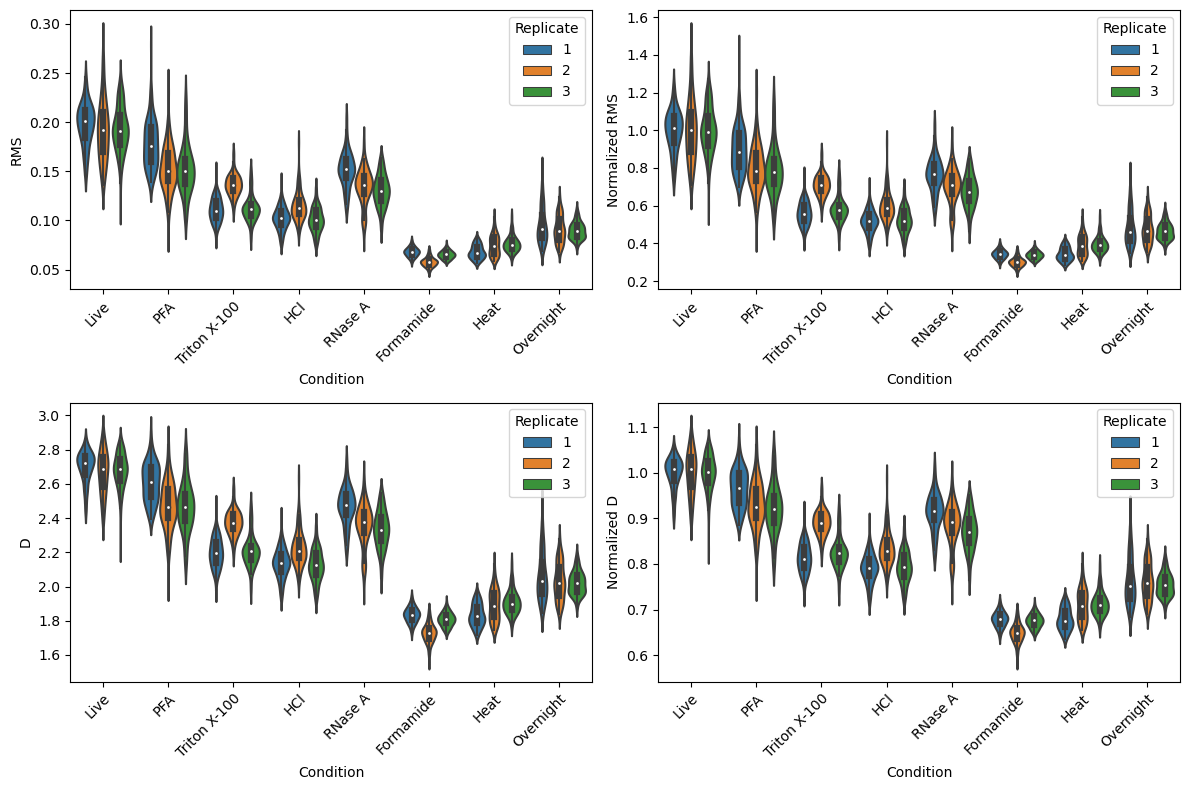

In [7]:
plotdata = fish_paper_data[fish_paper_data.Experiment=='Full 3D FISH Protocol'].copy()
plotdata['Condition'] = plotdata['Condition'].astype('string')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), layout='tight')
sns.violinplot(data=plotdata,x='Condition',y='RMS',hue='Replicate',ax=axs[0,0])
labels = [item.get_text() for item in axs[0,0].get_xticklabels()]
axs[0,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized RMS',hue='Replicate',ax=axs[0,1])
axs[0,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='D',hue='Replicate',ax=axs[1,0])
axs[1,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized D',hue='Replicate',ax=axs[1,1])
axs[1,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')

plt.show()

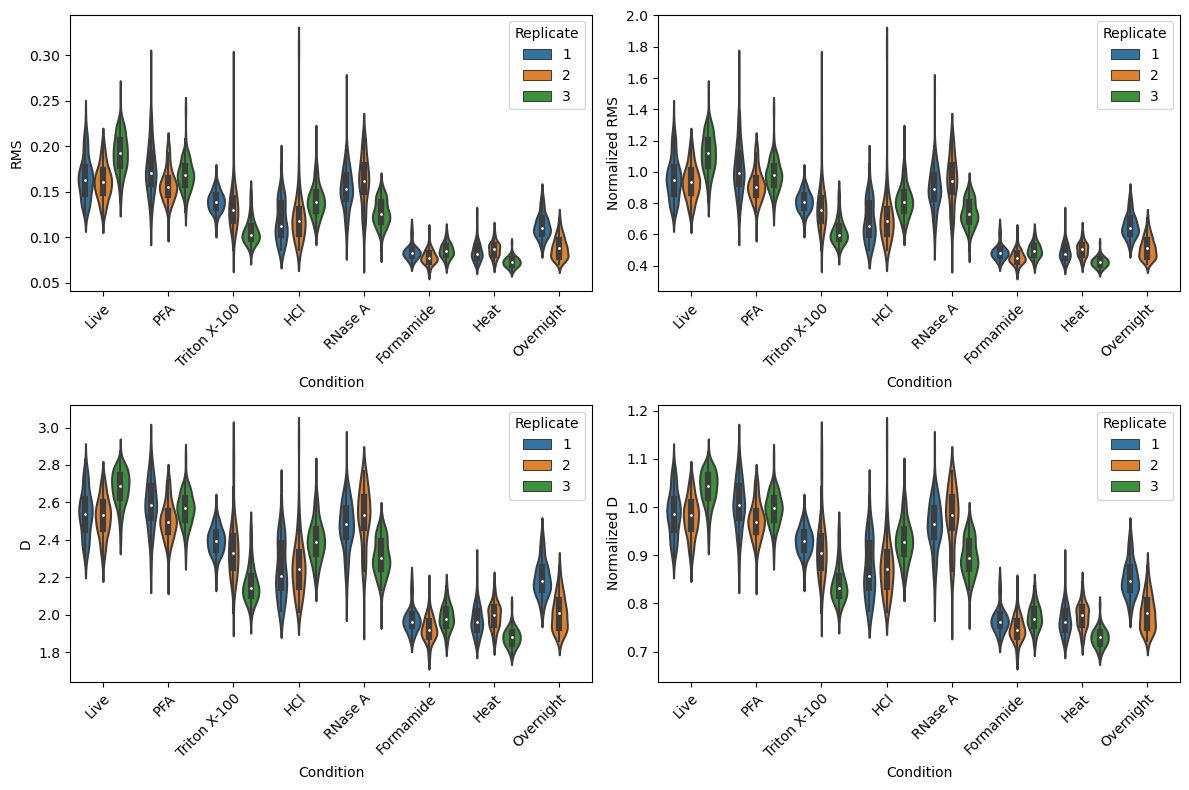

In [8]:
plotdata = fish_paper_data[fish_paper_data.Experiment=='Individual 3D FISH Reagents'].copy()
plotdata['Condition'] = plotdata['Condition'].astype('string')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), layout='tight')
sns.violinplot(data=plotdata,x='Condition',y='RMS',hue='Replicate',ax=axs[0,0])
labels = [item.get_text() for item in axs[0,0].get_xticklabels()]
axs[0,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized RMS',hue='Replicate',ax=axs[0,1])
axs[0,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='D',hue='Replicate',ax=axs[1,0])
axs[1,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized D',hue='Replicate',ax=axs[1,1])
axs[1,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')

plt.show()

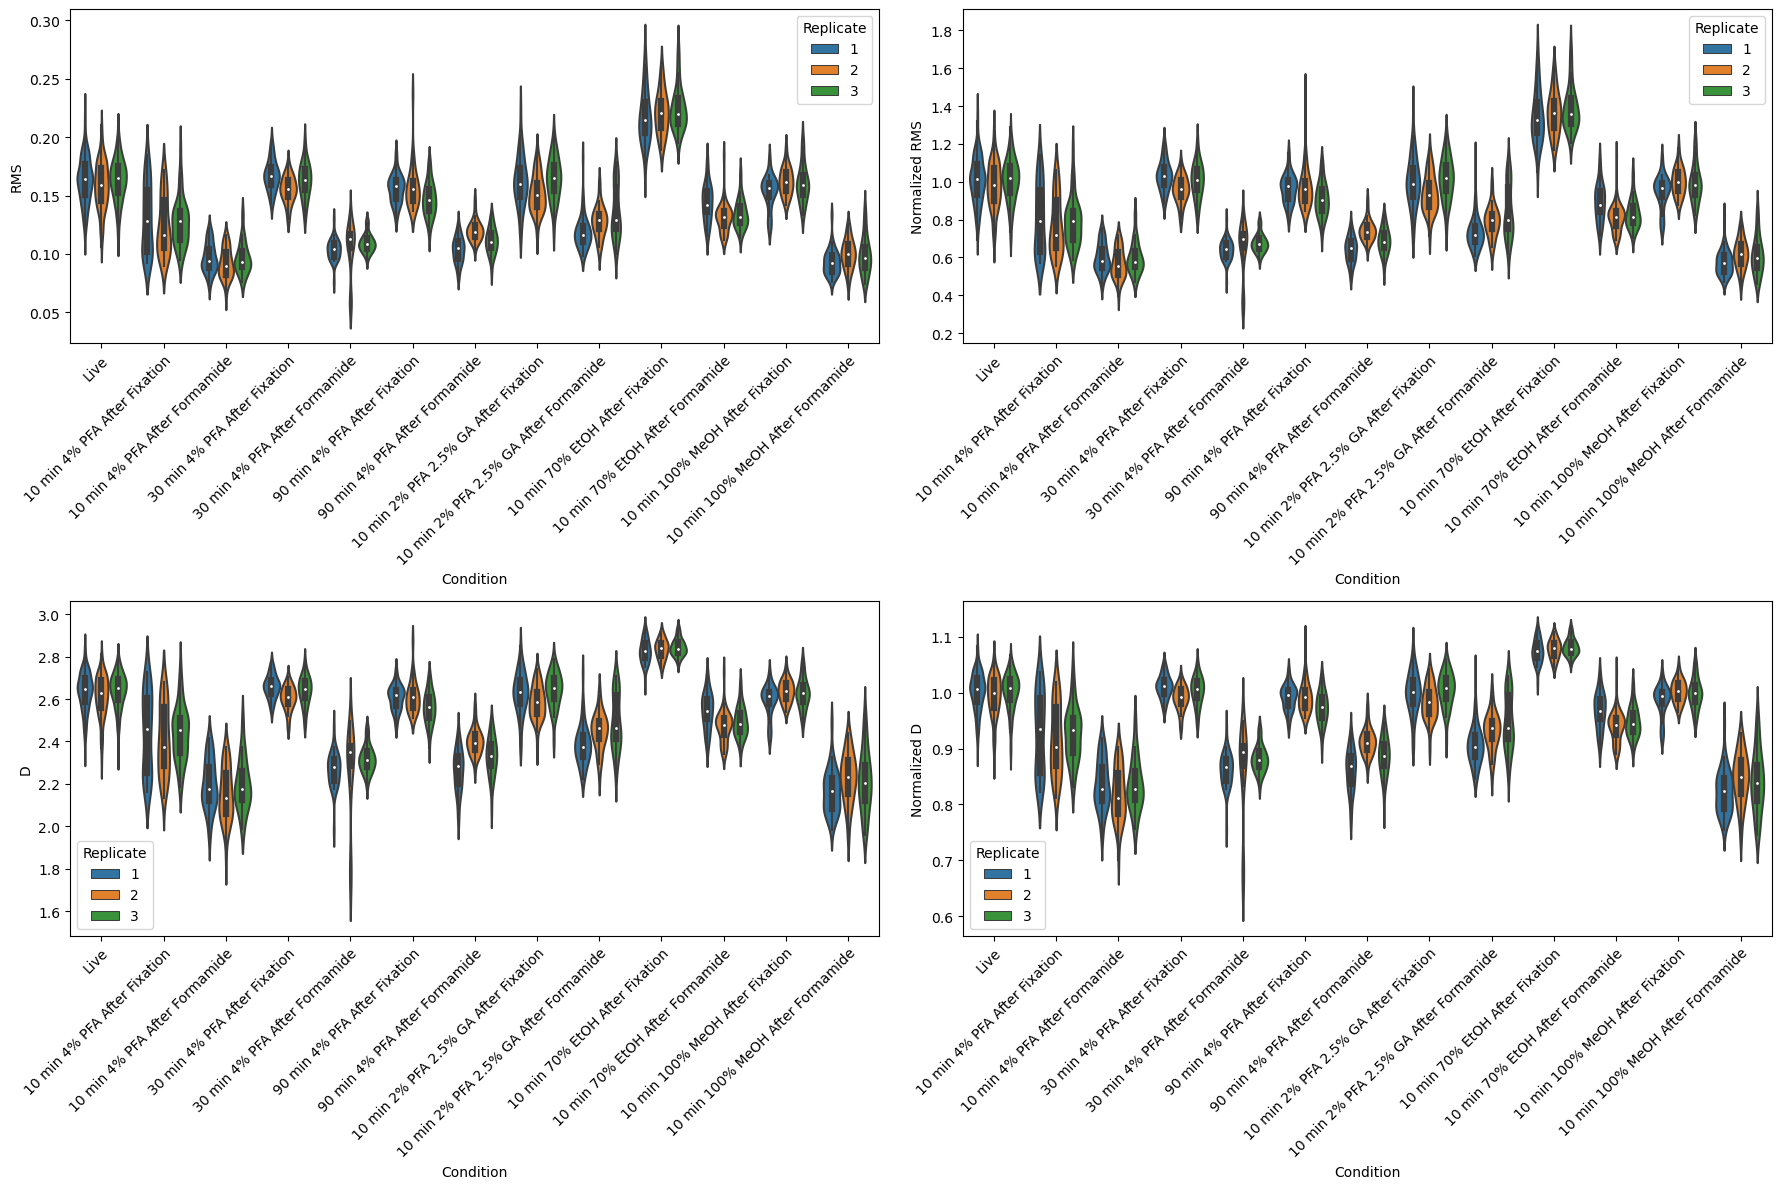

In [9]:
plotdata = fish_paper_data[fish_paper_data.Experiment=='Fixation Optimization'].copy()
plotdata['Condition'] = plotdata['Condition'].astype('string')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(18, 12), layout='tight')
sns.violinplot(data=plotdata,x='Condition',y='RMS',hue='Replicate',ax=axs[0,0])
labels = [item.get_text() for item in axs[0,0].get_xticklabels()]
axs[0,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized RMS',hue='Replicate',ax=axs[0,1])
axs[0,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='D',hue='Replicate',ax=axs[1,0])
axs[1,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized D',hue='Replicate',ax=axs[1,1])
axs[1,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')

plt.show()

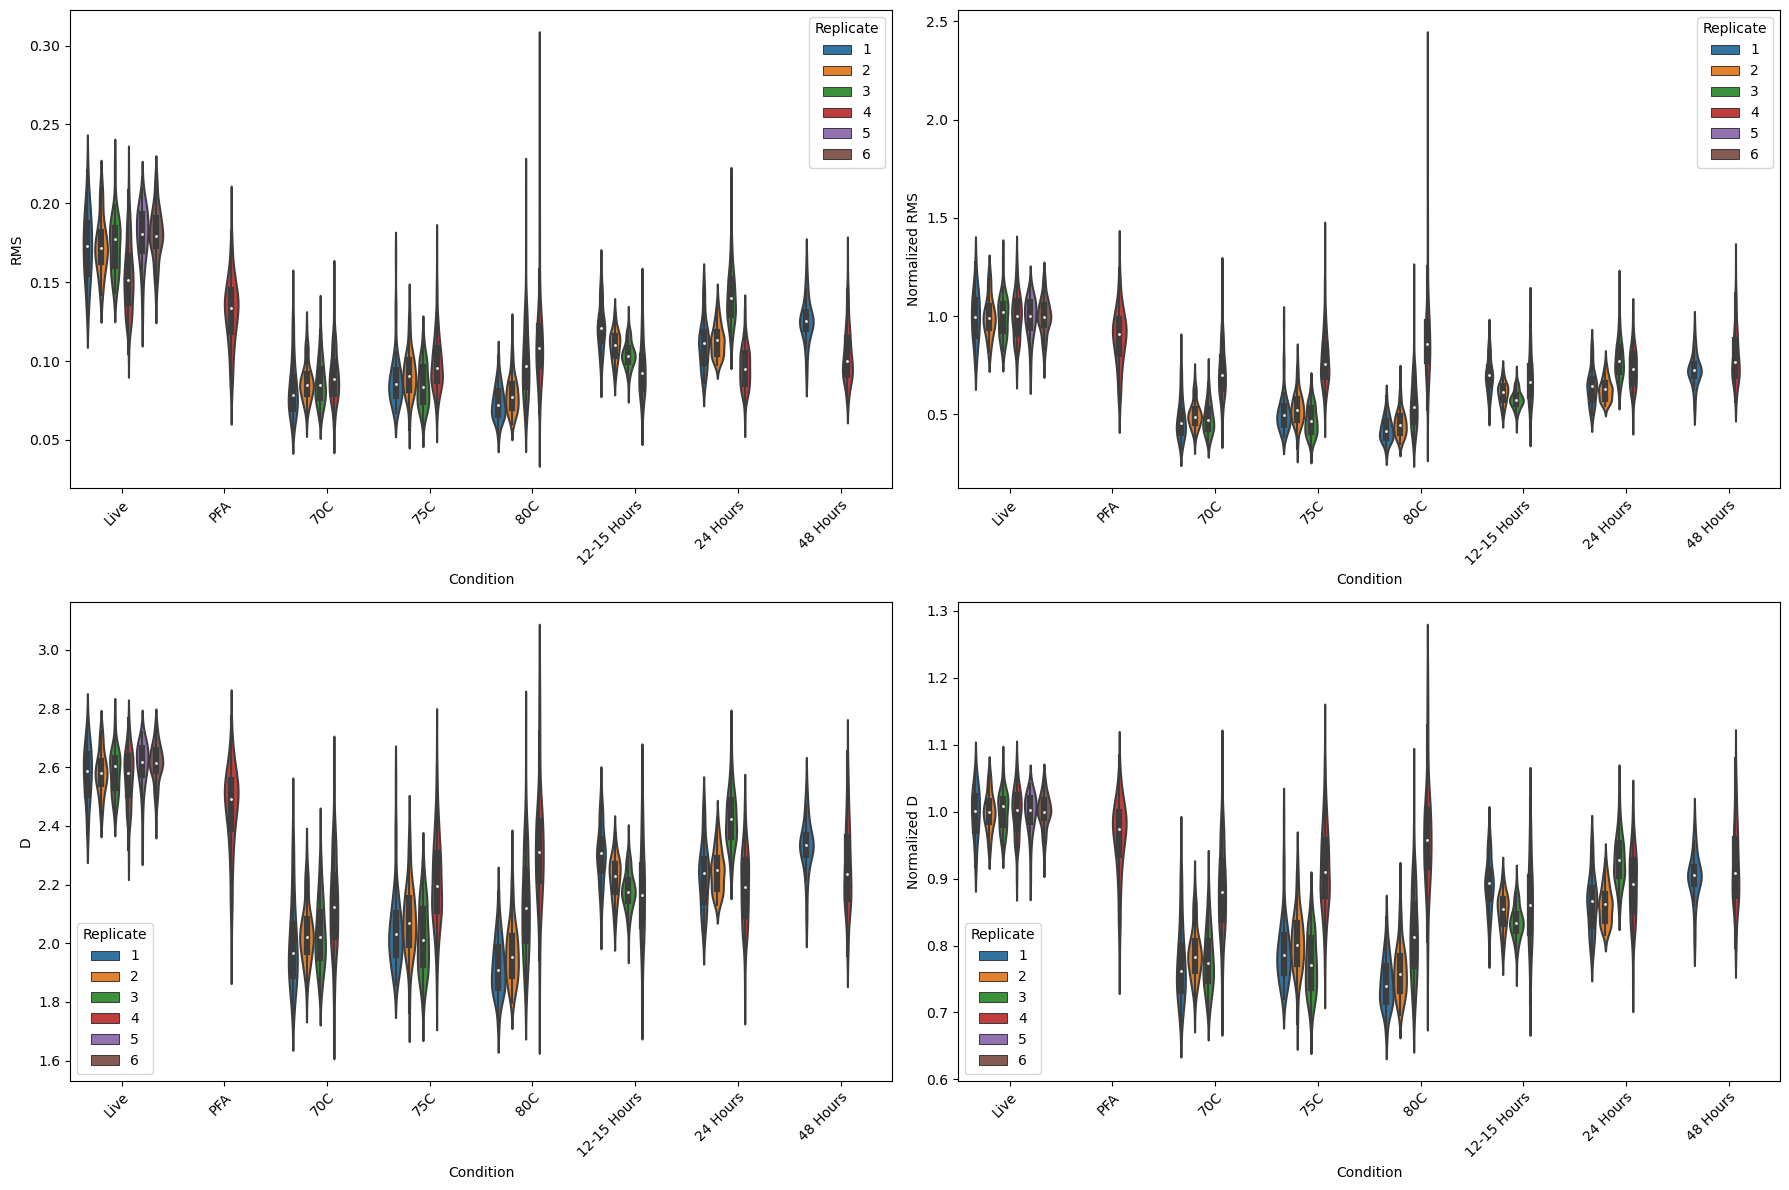

In [10]:
plotdata = fish_paper_data[fish_paper_data.Experiment=='Optimization After Formamide'].copy()
plotdata['Condition'] = plotdata['Condition'].astype('string')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(18, 12), layout='tight')
sns.violinplot(data=plotdata,x='Condition',y='RMS',hue='Replicate',ax=axs[0,0])
labels = [item.get_text() for item in axs[0,0].get_xticklabels()]
axs[0,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized RMS',hue='Replicate',ax=axs[0,1])
axs[0,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='D',hue='Replicate',ax=axs[1,0])
axs[1,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized D',hue='Replicate',ax=axs[1,1])
axs[1,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')

plt.show()

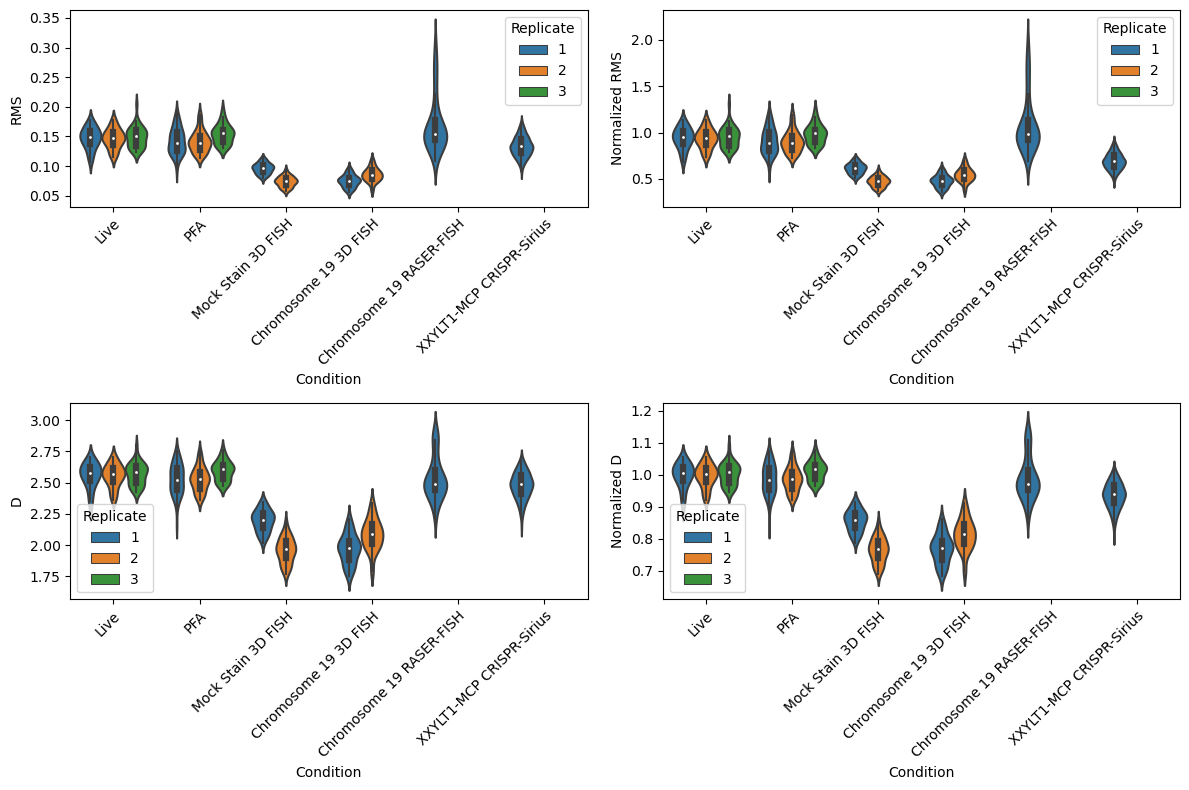

In [11]:
plotdata = fish_paper_data[fish_paper_data.Experiment=='Protocol Comparison'].copy()
plotdata['Condition'] = plotdata['Condition'].astype('string')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), layout='tight')
sns.violinplot(data=plotdata,x='Condition',y='RMS',hue='Replicate',ax=axs[0,0])
labels = [item.get_text() for item in axs[0,0].get_xticklabels()]
axs[0,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized RMS',hue='Replicate',ax=axs[0,1])
axs[0,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='D',hue='Replicate',ax=axs[1,0])
axs[1,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized D',hue='Replicate',ax=axs[1,1])
axs[1,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')

plt.show()

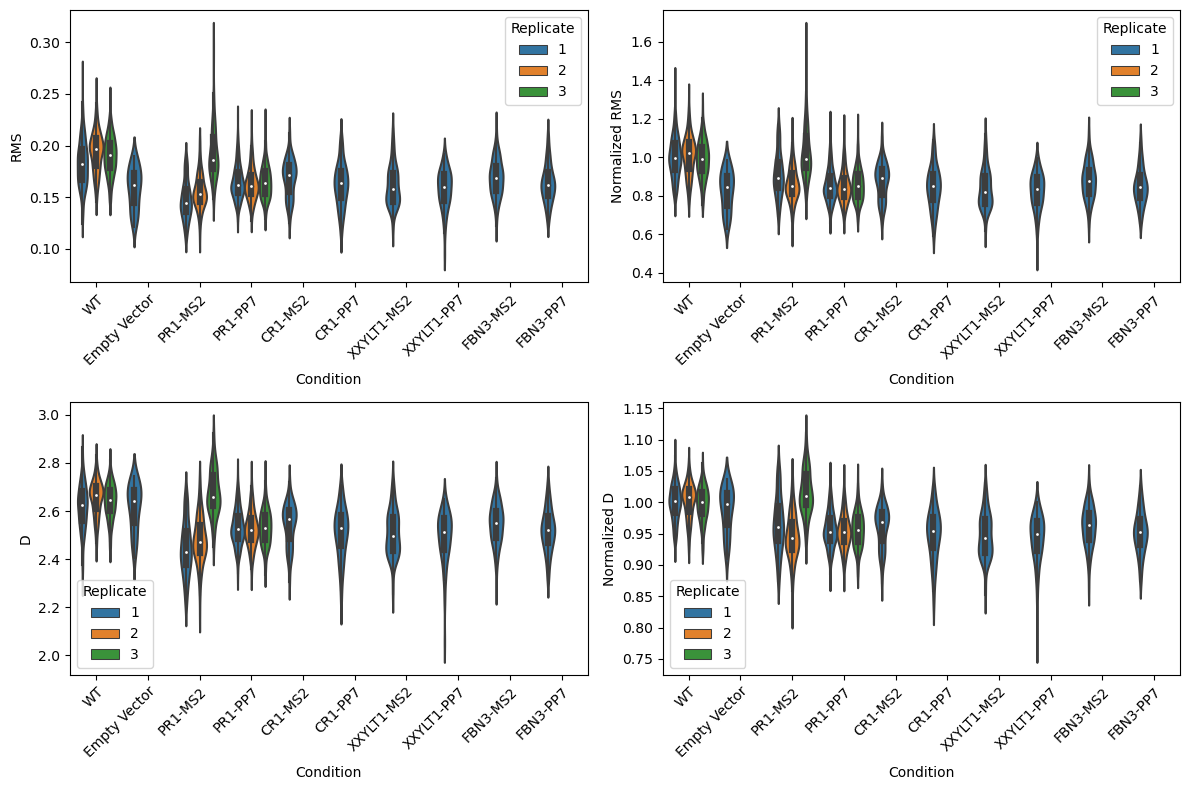

In [12]:
plotdata = fish_paper_data[fish_paper_data.Experiment=='CRISPR-Sirius Comparison'].copy()
plotdata['Condition'] = plotdata['Condition'].astype('string')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), layout='tight')
sns.violinplot(data=plotdata,x='Condition',y='RMS',hue='Replicate',ax=axs[0,0])
labels = [item.get_text() for item in axs[0,0].get_xticklabels()]
axs[0,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized RMS',hue='Replicate',ax=axs[0,1])
axs[0,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='D',hue='Replicate',ax=axs[1,0])
axs[1,0].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
sns.violinplot(data=plotdata,x='Condition',y='Normalized D',hue='Replicate',ax=axs[1,1])
axs[1,1].set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')

plt.show()

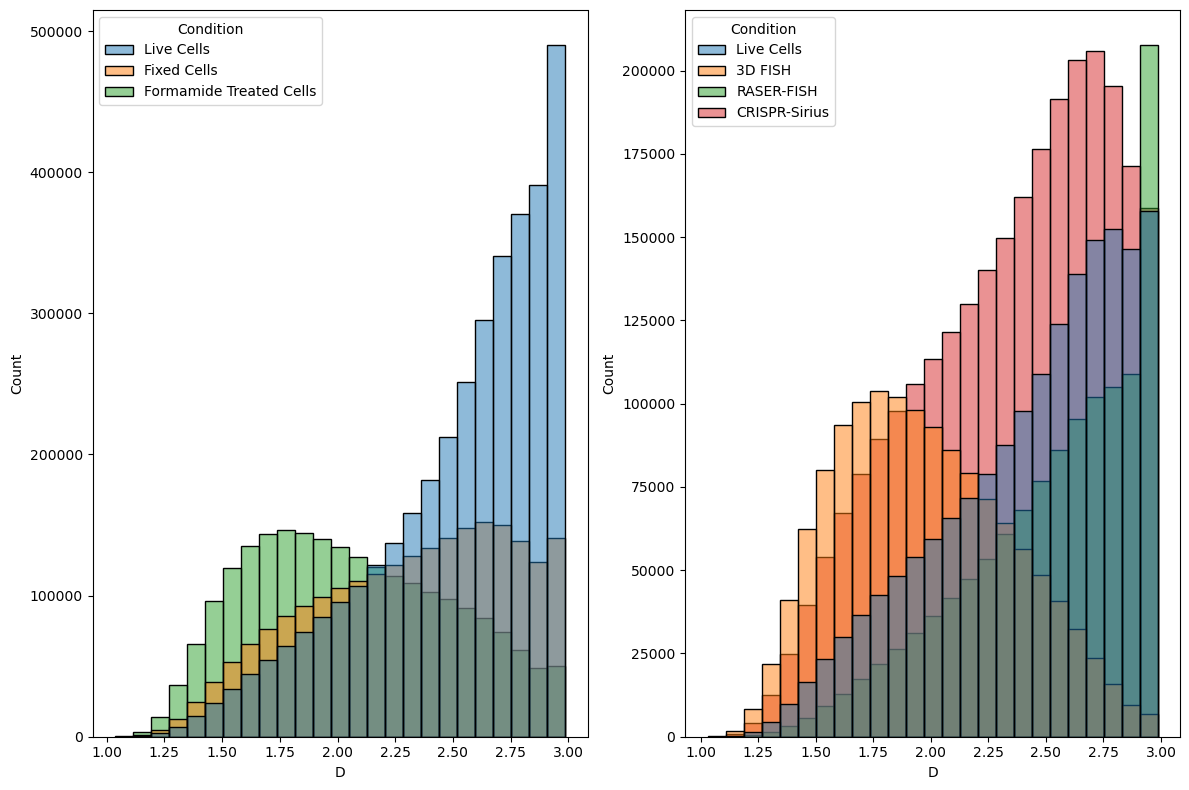

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 8), layout='tight')

plotdata = pwshistdata[pwshistdata['Figure']==1]
sns.histplot(data=plotdata,x='D',hue='Condition',bins=25,ax=axs[0])

plotdata = pwshistdata[pwshistdata['Figure']==3]
sns.histplot(data=plotdata,x='D',hue='Condition',bins=25,ax=axs[1])

plt.show()

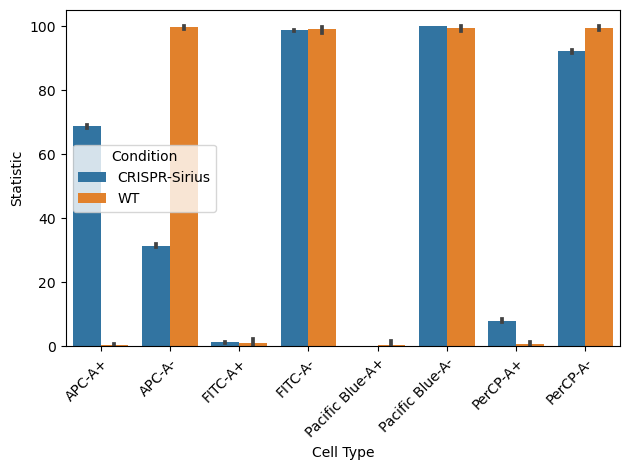

In [14]:
fig, ax = plt.subplots(layout='tight')
sns.barplot(data=tr_eff_paper[tr_eff_paper['Cell Type'].str.contains('-A')],x='Cell Type',y='Statistic',hue='Condition')
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

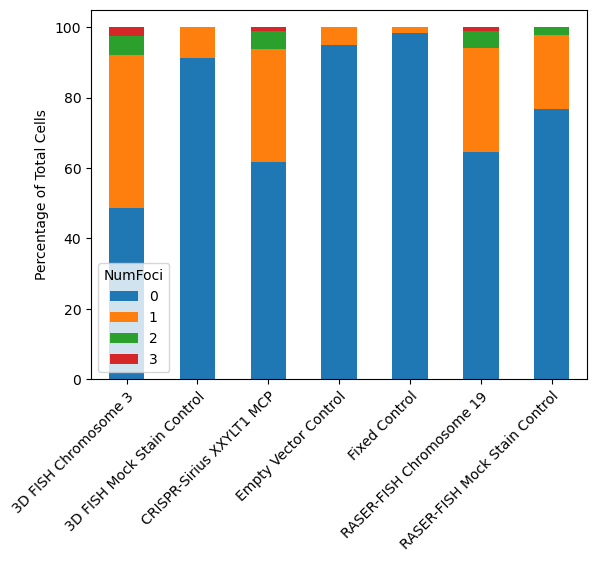

In [15]:
foci_nums = allfoci.groupby('Condition')['NumFoci'].value_counts(normalize=True)*100

fig, ax = plt.subplots()
foci_nums.unstack('NumFoci').plot.bar(stacked=True,ax=ax)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('')
ax.set_ylabel('Percentage of Total Cells')
plt.show()